In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

In [2]:
script_dir = os.getcwd()
parent_dir = os.path.dirname(os.path.dirname(script_dir))
data_dir = os.path.join(parent_dir, "UCB_results")
print("模拟结果的位置:", data_dir)

模拟结果的位置: e:\VS code project\UCB_results


In [3]:
methods = [
    {'name': 'MA-UCB', 'csv': 'MA_UCB_simulation_results.csv', 'column': 'mean_accuracy', 'color': "#58a9e4"},  # 蓝色
    {'name': 'AP-UCB(Maximum)', 'csv': 'AP_UCB_simulation_results.csv', 'column': 'mean_accuracy_max', 'color': "#ec9e59"},  # 橙色
    {'name': 'AP-UCB(Minimum)', 'csv': 'AP_UCB_simulation_results.csv', 'column': 'mean_accuracy_min', 'color': "#5be95b"},  # 绿色
    {'name': 'AP-UCB(Median)', 'csv': 'AP_UCB_simulation_results.csv', 'column': 'mean_accuracy_mean', 'color': "#b26df3"}  # 紫色
]

In [4]:
# 加载和验证数据集
def load_and_validate_data(methods, data_dir):
    datasets = []
    try:
        for method in methods:
            csv_path = os.path.join(data_dir, method['csv'])
            if not os.path.exists(csv_path):
                raise FileNotFoundError(f"CSV file not found: {csv_path}")
            df = pd.read_csv(csv_path)
            
            # 确保 T 列为数值型
            df['T'] = pd.to_numeric(df['T'], errors='coerce')
            if df['T'].isnull().any():
                raise ValueError(f"Invalid T values in {method['name']} dataset")
            
            # 解析 mean_accuracy 列
            def parse_accuracy(x):
                try:
                    return float(ast.literal_eval(x)) if isinstance(x, str) else float(x)
                except ValueError:
                    print(f"Failed to parse {method['column']} {x} in {method['name']} dataset")
                    raise
            
            try:
                df[method['column']] = df[method['column']].apply(parse_accuracy)
            except ValueError as e:
                print(f"Error parsing {method['column']} in {method['name']} dataset: {e}")
                raise
            
            datasets.append({
                'name': method['name'],
                'df': df,
                'column': method['column'],
                'color': method['color']
            })
        print("All datasets loaded successfully")
        return datasets
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        raise
datasets = load_and_validate_data(methods, data_dir)

All datasets loaded successfully


 MA-UCB:
 0    0.446242
1    0.480023
2    0.494831
3    0.517909
4    0.536201
5    0.551372
6    0.560308
7    0.576733
Name: mean_accuracy, dtype: float64
 AP-UCB(Maximum):
 0    0.422810
1    0.444431
2    0.455220
3    0.476688
4    0.487242
5    0.498719
6    0.515094
7    0.523316
Name: mean_accuracy_max, dtype: float64
 AP-UCB(Minimum):
 0    0.472744
1    0.491477
2    0.502326
3    0.511719
4    0.525731
5    0.534445
6    0.550722
7    0.552886
Name: mean_accuracy_min, dtype: float64
 AP-UCB(Median):
 0    0.452381
1    0.483545
2    0.485485
3    0.504689
4    0.516236
5    0.519235
6    0.540741
7    0.551145
Name: mean_accuracy_mean, dtype: float64


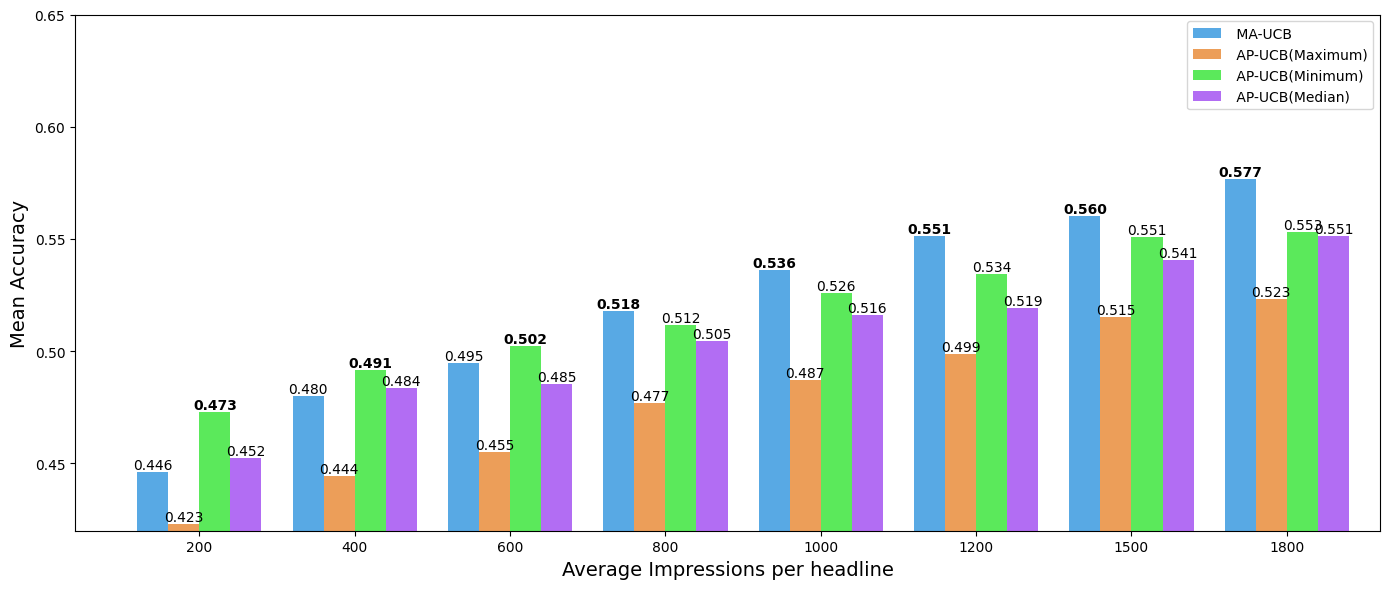

In [5]:
# 定义 T 值和柱状图参数
T_values = [200, 400, 600, 800, 1000, 1200, 1500, 1800]
T_indices = [i + 0.6 for i in range(len(T_values))]  # T对应的区域的中心位置
bar_width = 0.2
offset = [-0.3, -0.1, 0.1, 0.3]  # 四个柱状体的相对位置

def plot_accuracy_bar(datasets, T_values, T_indices, bar_width, offset):
    plt.figure(figsize=(14, 6), dpi=100)  # 12 英寸宽，DPI=100 确保间距
    
    # 收集所有准确率，用于动态设置 Y 轴范围
    all_accuracies = []
    for i, dataset in enumerate(datasets):
        df = dataset['df']
        column = dataset['column']
        color = dataset['color']
        label = f" {dataset['name']}"
        
        # 收集准确率
        all_accuracies.extend(df[column].tolist())
        
        # 打印准确率
        print(f"{label}:\n", df[column])
        
        # 绘制分组柱状图
        x_positions = [T_indices[T_values.index(t)] + offset[i] for t in df['T']]
        bars = plt.bar(x_positions, df[column], width=bar_width, color=color, label=label)
    
    # 标注数值并加粗最大值
    for t_idx, t in enumerate(T_values):
        accuracies = []
        for dataset in datasets:
            df = dataset['df']
            value = df[df['T'] == t][dataset['column']].iloc[0] if t in df['T'].values else 0.0
            accuracies.append((value, dataset['name'], dataset['color']))
        
        # 找到最大值
        max_accuracy = max(accuracies, key=lambda x: x[0])[0] if accuracies else 0.0
        
        # 标注数值
        for i, (value, name, color) in enumerate(accuracies):
            x_pos = t_idx + 0.6 + offset[i]
            fontweight = 'bold' if value == max_accuracy else 'normal'
            plt.text(x_pos, value, f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight=fontweight)
    
    # 动态设置 Y 轴范围
    if all_accuracies:
        y_min = min(all_accuracies)
        y_max = max(all_accuracies)
        y_range = y_max - y_min
        y_margin = y_range * 0.2 if y_range > 0 else 0.1
        plt.ylim(0.42, 0.65)
    else:
        print("Warning: No accuracy values calculated, using default Y-axis range")
        plt.ylim(0, 1)
    
    # 设置图表样式
    plt.xlabel(r'Average Impressions per headline', fontsize=14)
    plt.ylabel('Mean Accuracy', fontsize=14)
    plt.xticks(T_indices, T_values)  # x 轴显示离散 T 值
    plt.xlim(-0.2, len(T_values) + 0.2)  # 调整 x 轴范围以适配离散区域
    plt.legend(loc='best', ncol=1, fontsize=10)
    plt.tight_layout()
    plt.show()
    
# 调用柱状图可视化
plot_accuracy_bar(datasets, T_values, T_indices, bar_width, offset)

 先验选择比例热力图可视化

In [7]:
script_dir = os.getcwd()
parent_dir = os.path.dirname(os.path.dirname(script_dir))
data_dir = os.path.join(parent_dir, "UCB_results")
raw_data_path = os.path.join(parent_dir, "Cross Attention for Combo", "Merge_Combo_RESULT", "full_prior_predictions.csv")
attrs_path = os.path.join(data_dir, "MA_UCB_aggregated_attrs.csv")
print(f"先验被选择情况的数据路径: {attrs_path}")
print(f"原始总数据路径: {raw_data_path}")

先验被选择情况的数据路径: e:\VS code project\UCB_results\MA_UCB_aggregated_attrs.csv
原始总数据路径: e:\VS code project\Cross Attention for Combo\Merge_Combo_RESULT\full_prior_predictions.csv


In [22]:
try:
    raw_df = pd.read_csv(raw_data_path)
    required_columns = ['test_id', 'CTR', 'headline'] + [f'pred_CTR_{i}' for i in range(1, 64)]
    if not all(col in raw_df.columns for col in required_columns):
        raise ValueError(f"Missing required columns in raw dataset: {required_columns}")
    if raw_df[required_columns].isnull().any().any():
        raise ValueError("Raw dataset contains missing values in required columns")
except FileNotFoundError as e:
    print(f"Error loading raw dataset: {e}")
    raise

combinations_path = os.path.join(parent_dir, "Cross Attention for Combo", "Merge_Combo_RESULT","all_combinations.csv")  # 假设路径与 raw_data_path 类似，需调整
try:
    combos_df = pd.read_csv(combinations_path)
    # 创建映射字典：{'pred_CTR_1': 'Concreteness', 'pred_CTR_2': 'Numeric', ...}
    pred_to_name = dict(zip(combos_df['New_Column_Name'], combos_df['Combination']))
except FileNotFoundError as e:
    print(f"Error loading all_combinations.csv: {e}")
    raise

test_id = 1
raw_df_test = raw_df[raw_df['test_id'] == test_id]
if raw_df_test.empty:
    raise ValueError(f"No data found for test_id={test_id} in raw dataset")

opt_cue = {}
pred_columns = [f'pred_CTR_{i}' for i in range(1, 64)]
for idx, row in raw_df_test.iterrows():
    headline = row['headline']
    # 获取所有 pred_CTR_i 值
    pred_values = [row[f'pred_CTR_{i}'] for i in range(1, 64)]
    # 找到最大的 5 个 pred_i（索引从 1 开始）
    top5_indices = np.argsort(pred_values)[-3:] + 1  # 降序排序，取最后 5 个，+1 因为 pred_i 从 1 开始
    opt_cue[headline] = [f'pred_{i}' for i in top5_indices]

# 新增: 打印映射后的 opt_cue（显示 Combination 名称）
mapped_opt_cue = {}
for headline, preds in opt_cue.items():
    mapped_preds = [f"{pred} ({pred_to_name.get(pred.replace('pred_', 'pred_CTR_'), 'Unknown')})" for pred in preds]
    mapped_opt_cue[headline] = mapped_preds
print(f"Mapped opt_cue for test_id={test_id}: {mapped_opt_cue}")

Mapped opt_cue for test_id=1: {"hey dude. if you have an older brother, there's a bigger chance you're gay.": ['pred_11 (sentiment_Pronoun_Label)', 'pred_61 (sentiment_Concreteness_Label_Numeric_Label_Suspense_Label_Pronoun_Label)', 'pred_26 (sentiment_Concreteness_Label_Numeric_Label)'], "here's the science, here's the gay. open your brain, they were born that way!": ['pred_61 (sentiment_Concreteness_Label_Numeric_Label_Suspense_Label_Pronoun_Label)', 'pred_26 (sentiment_Concreteness_Label_Numeric_Label)', 'pred_11 (sentiment_Pronoun_Label)'], "i've got some news for you. being gay is genetic. being irrationally afraid of gay, not so much.": ['pred_26 (sentiment_Concreteness_Label_Numeric_Label)', 'pred_46 (sentiment_length_Numeric_Label_Pronoun_Label)', 'pred_61 (sentiment_Concreteness_Label_Numeric_Label_Suspense_Label_Pronoun_Label)'], 'science fact: gay science, like straight science, is really just plain old fact science': ['pred_26 (sentiment_Concreteness_Label_Numeric_Label)', 

In [23]:
try:
    df = pd.read_csv(attrs_path)
    df['chosen_attr'] = df['chosen_attr'].apply(ast.literal_eval)
except FileNotFoundError as e:
    print(f"Error loading aggregated attrs dataset: {e}")
    raise

df_test = df[(df['T'] == 1500) & (df['test_id'] == test_id)]
if df_test.empty:
    raise ValueError(f"No data found for T=1500 and test_id={test_id} in aggregated dataset")

# 获取标题序号
arms = sorted(df_test['headline'].unique())
print(f"Unique headline for T=1500, test_id={test_id}: {arms}")

# 步骤5: 初始化矩阵存储比例（行=pred_i，列=chosen_arm）
pred_counts = {arm: np.zeros(63) for arm in arms}

Unique headline for T=1500, test_id=1: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


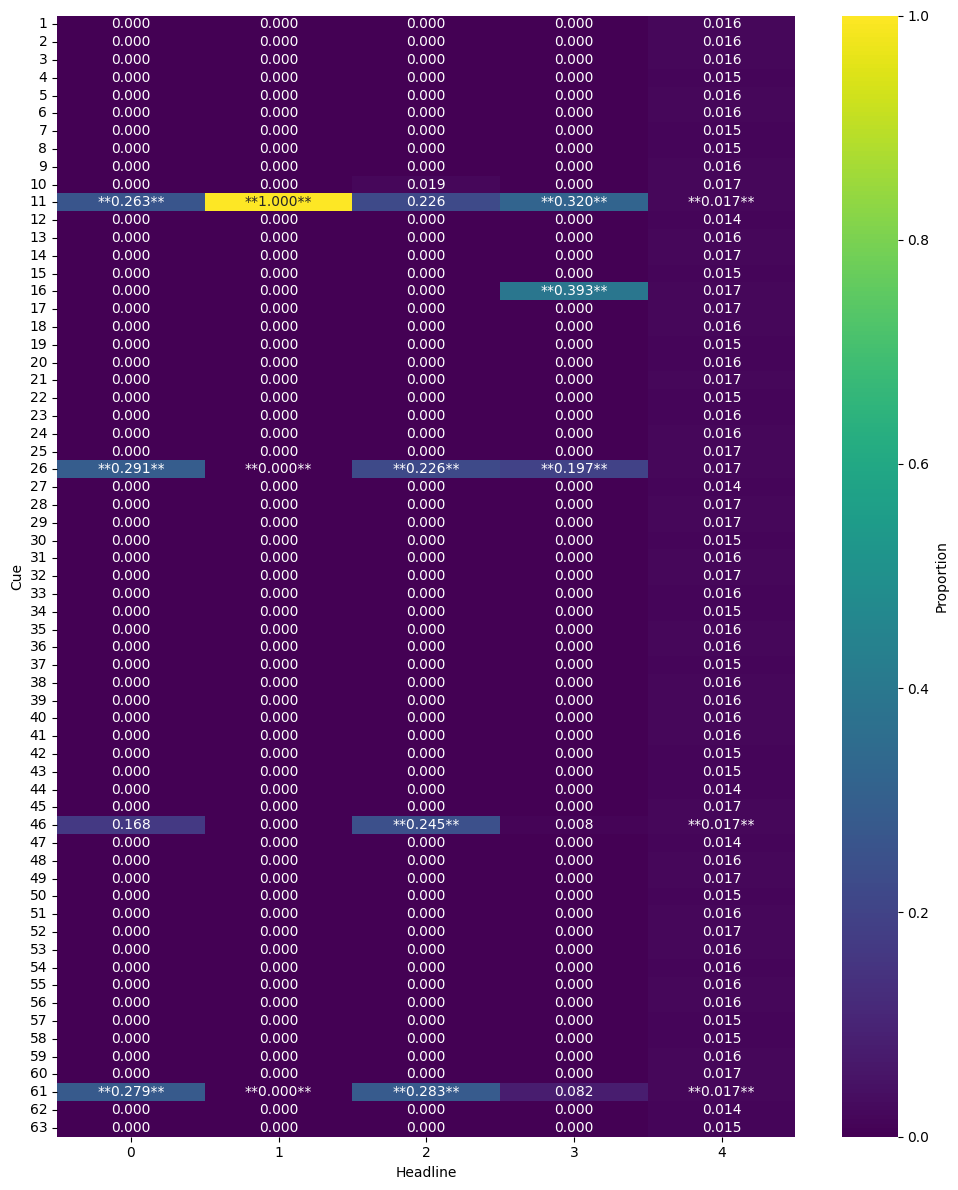

In [30]:
# 步骤6: 聚合每个 chosen_arm 下的 pred_i 选择次数
for _, row in df_test.iterrows():
    arm = row['headline']
    attr_dict = row['chosen_attr']
    for pred, count in attr_dict.items():
        i = int(pred.split('_')[1]) - 1  # 'pred_1' -> i=0
        pred_counts[arm][i] += count

# 步骤7: 计算每个 arm 的总选择次数
total_counts = {arm: np.sum(counts) for arm, counts in pred_counts.items()}

# 步骤8: 计算比例（所有 pred_i）
proportions = np.zeros((63, len(arms)))  # 63 行（pred_i），arm 列
for arm_idx, arm in enumerate(arms):
    for i in range(63):
        proportions[i, arm_idx] = pred_counts[arm][i] / total_counts[arm] if total_counts[arm] > 0 else 0

# 步骤9: 构建 DataFrame：行=pred_i (1-63)，列=chosen_arm
prop_df = pd.DataFrame(proportions, index=range(1, 64), columns=arms)
prop_df.index.name = 'Cue'
prop_df.columns.name = 'Headline'

# 步骤10: 创建 annot 矩阵，opt_cue 的值加粗
annot = np.full_like(proportions, '', dtype=object)  # 空的 annot 矩阵
for arm_idx, arm in enumerate(arms):
    headline = raw_df_test[raw_df_test.index == raw_df_test.index[arm]]['headline'].iloc[0]
    opt_cue_indices = [int(pred.split('_')[1]) - 1 for pred in opt_cue[headline]]  # opt_cue 的索引
    for i in range(63):
        if i in opt_cue_indices:
            annot[i, arm_idx] = f'**{proportions[i, arm_idx]:.3f}**'  # 加粗 opt_cue 值
        else:
            annot[i, arm_idx] = f'{proportions[i, arm_idx]:.3f}'  # 正常显示其他值

plt.figure(figsize=(10, 12))
sns.heatmap(prop_df, annot=annot, fmt='', cmap='viridis', cbar_kws={'label': 'Proportion'})
# plt.title(f'Proportion of Opt_Cue Selections for T=1500, test_id={test_id}')
plt.xlabel('Headline')
plt.ylabel('Cue')
plt.tight_layout()
# plt.savefig(f'opt_cue_heatmap_T1500_test_id_{test_id}.png')
plt.show()

